# Multiclass Support Vector Machine exercise

【笔记】这是大作业的第一课，也是一个机器学习的完整流程。包括加载数据、分组数据、交叉验证，可视化结果等。

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

# 引入一些必须的库。 基本上用到了import的所有语法。
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# 在jupyter中使用内嵌绘图的trick。
# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 修改了外部的pyton文件后， jupyter自动重新load模块
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# 需要预先下载CIFAR-10 http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz 解压至cifar-10-batches-py目录
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
# 封装在data_utils.py一个helper函数中
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print ('Training data shape: ', X_train.shape)
print ('Training labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


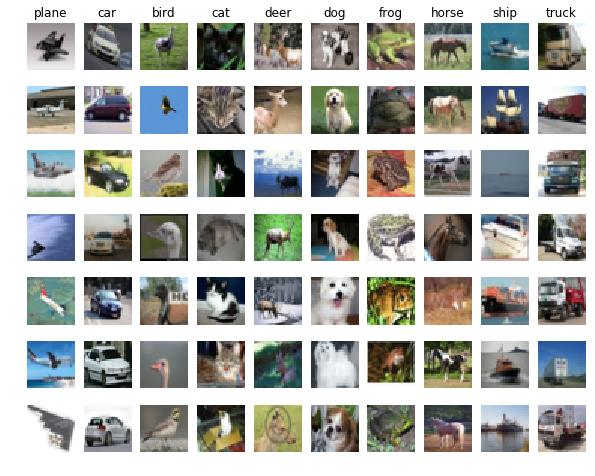

In [3]:
# 随机从训练集的每个分类中找到一些图片进行显示。
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
#这里分类硬编码，其实可以从CIFAR-10的batches.meta读取。
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    # 仅保留当前类别的索引。每个分类5000个。
    # np.flatnonzero 等同于 a.ravel().nonzero()[0]。此处因为y_train是一维的，因此下面用np.nonzero(y_train == y)[0]也可以。
    idxs = np.flatnonzero(y_train == y)
    # 随机选择7个样本
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# 从训练集中分离出1000个验证集，随机选择500个作为开发集，以便让验证算法的效率更高。
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# 下面的切片，使用了nparray的花式索引，Fancy indexing方法，传入一个列表或nparray
# 换做nparray的切片可以得到相同的结果，但不知道效率相比如何。 例如： X_val = X_train[num_training : num_training + num_validation]
# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# 作为随机选择的开发集，只能使用花式索引了，无法使用切片。
# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# 预处理，一行是一个图片。每个像素的rgb顺序是连续的。
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print ('Training data shape: ', X_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Test data shape: ', X_test.shape)
print ('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


(3072,)
[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


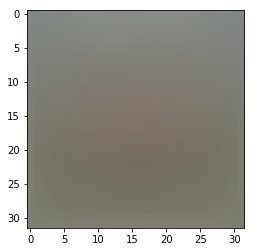

In [6]:
# 对每个维度的特征做归一化处理（normalization ）让所有数值分布的区间变为[-1, 1]。
# 针对图像像素，本来每个像素减去128再归一化也能达到效果。为什么还要麻烦的求每个像素点的均值？因为这样求得的归一化更加集中，避免不同维度数值干扰。
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
# axis=0,轴是哪个方向，哪个方向就被压平。求得了整个测试集的平均图像。每个像素点都是所有测试集图片该位置像素点的平均值。
mean_image = np.mean(X_train, axis=0)
print(mean_image.shape)
print (mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
# 这里用了nparray的vectorize减法
# 【问题】训练集、验证集、测试集都使用训练集的平均图像，还是应该每个集合减去自己的平均图像？
# 个人认为，严格来讲， 对于train, val, dev没问题。 但对于test应该计算自己的mean_image
print(mean_image.shape)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

(3072,)


In [8]:
# 将bias也加入weights矩阵，加入1列。
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print (X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# Weight一次能够计算全部分类
# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

# 计算针对W的损失及梯度
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print ('loss: %f' % (loss, ))

loss: 9.161258


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

因为在计算lost的过程中，可以利用margin的判断，来插入计算分析梯度的代码。因此 `svm_loss_naive` 同时计算了loss与gradient。 参见代码。

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# 结果证明：利用有限差值与利用微分分析计算的梯度，几乎相同！
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# 第一次不使用正则化
# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
# 仅使用返回值的loss，这个lamda将函数的其他参数指定，而仅留下w作为新参数。
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# 第二次使用正则化，正则化的强度超参数使用100？
# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

ix: (611, 3)
numerical: 21.183396 analytic: 21.183396, relative error: 1.351416e-11
ix: (2425, 7)
numerical: -8.537760 analytic: -8.537760, relative error: 1.063536e-10
ix: (889, 3)
numerical: 13.977937 analytic: 13.977937, relative error: 1.838362e-11
ix: (611, 6)
numerical: 27.270288 analytic: 27.270288, relative error: 1.043721e-11
ix: (2264, 9)
numerical: 19.444000 analytic: 19.444000, relative error: 1.708405e-11
ix: (97, 6)
numerical: 16.350316 analytic: 16.350316, relative error: 3.191948e-13
ix: (343, 2)
numerical: 7.946061 analytic: 7.946061, relative error: 1.453646e-13
ix: (39, 1)
numerical: -20.574947 analytic: -20.574947, relative error: 7.445177e-12
ix: (910, 0)
numerical: -20.718403 analytic: -20.718403, relative error: 1.261379e-11
ix: (1805, 5)
numerical: -9.849361 analytic: -9.849361, relative error: 5.141489e-12
ix: (1554, 7)
numerical: 21.990922 analytic: 21.990922, relative error: 5.036354e-12
ix: (1506, 1)
numerical: -1.375111 analytic: -1.375111, relative error: 

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*
*提示：SVM损失函数非严格意义上的可微分*

**Your Answer:** 参考了答案：https://github.com/lightaime/cs231n/　他提到说：因为不是在所有点可微分，因此在不可微分的点附近，两种方法计算的结果差异很大。

In [11]:
# 从下面结果可以看到，python循环是非常耗费时间的。
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
time_naive = toc - tic
print ('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
time_vectorized = toc - tic
print ('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print ('loss difference: %f' % (loss_naive - loss_vectorized))
print ('speed difference: %f : 1' % (time_naive/time_vectorized))

Naive loss: 9.161258e+00 computed in 0.093246s
Vectorized loss: 9.161258e+00 computed in 0.014222s
loss difference: -0.000000
speed difference: 6.556427 : 1


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# 注意梯度是一个矩阵，弗罗贝尼乌斯范数（Frobenius norm）或希尔伯特-施密特范数（ Hilbert–Schmidt norm），与 Kn 上欧几里得范数非常类似，来自所有矩阵的空间上一个内积。
# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print ('difference: %f' % difference)

Naive loss and gradient: computed in 0.102272s
Vectorized loss and gradient: computed in 0.005014s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

下面的随机梯度下降，是使用小批量样本的随机梯度下降。

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
# 从下面的绘图中可以看出，迭代次数num_iters的设定，也需要多次实验获得。本例中大概800次后稳定。
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print ('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 787.176668
iteration 100 / 1500: loss 287.126078
iteration 200 / 1500: loss 107.751058
iteration 300 / 1500: loss 42.708253
iteration 400 / 1500: loss 19.080671
iteration 500 / 1500: loss 11.042213
iteration 600 / 1500: loss 6.709874
iteration 700 / 1500: loss 5.816272
iteration 800 / 1500: loss 5.168832
iteration 900 / 1500: loss 4.972325
iteration 1000 / 1500: loss 5.165476
iteration 1100 / 1500: loss 5.496446
iteration 1200 / 1500: loss 5.528328
iteration 1300 / 1500: loss 5.036310
iteration 1400 / 1500: loss 5.243017
That took 8.138644s


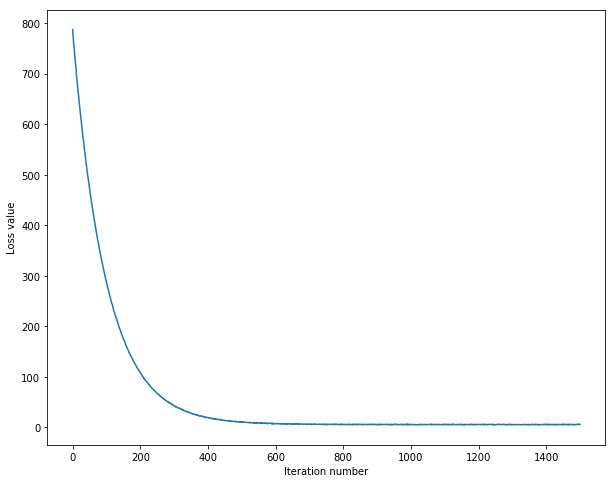

In [14]:
# 用图形将训练过程中的迭代次数与损失表示，是一个很直观的调试方法。
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
# 虽然梯度下降的曲线很漂亮，预测正确率也仅仅是37%左右。
y_train_pred = svm.predict(X_train)
print ('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print ('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.370204
validation accuracy: 0.379000


In [21]:
# 下面使用交叉验证的方法，来确定超参数。注意：num_iters有较大影响，使用默认值200次时，仅能得到27%左右的准确率。而设置为1500时，运算时间非常长。
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
# learning_rates = [1e-7, 5e-5]
regularization_strengths = [5e4, 1e5]
learning_rates = [1.4e-7, 1.5e-7, 1.6e-7]
regularization_strengths = [(1+i*0.1)*1e4 for i in range(-3, 3)] + [(2+i*0.1)*1e4 for i in range(-3, 3)]
print(regularization_strengths)

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=1500)
        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
        results[(lr, rs)] = train_accuracy, val_accuracy
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

[7000.0, 8000.0, 9000.0, 10000.0, 11000.0, 12000.0, 17000.0, 18000.0, 19000.0, 20000.0, 21000.0, 22000.0]
lr 1.400000e-07 reg 7.000000e+03 train accuracy: 0.381592 val accuracy: 0.396000
lr 1.400000e-07 reg 8.000000e+03 train accuracy: 0.383143 val accuracy: 0.384000
lr 1.400000e-07 reg 9.000000e+03 train accuracy: 0.386653 val accuracy: 0.381000
lr 1.400000e-07 reg 1.000000e+04 train accuracy: 0.386857 val accuracy: 0.389000
lr 1.400000e-07 reg 1.100000e+04 train accuracy: 0.387204 val accuracy: 0.390000
lr 1.400000e-07 reg 1.200000e+04 train accuracy: 0.384490 val accuracy: 0.394000
lr 1.400000e-07 reg 1.700000e+04 train accuracy: 0.380020 val accuracy: 0.385000
lr 1.400000e-07 reg 1.800000e+04 train accuracy: 0.374143 val accuracy: 0.359000
lr 1.400000e-07 reg 1.900000e+04 train accuracy: 0.380449 val accuracy: 0.377000
lr 1.400000e-07 reg 2.000000e+04 train accuracy: 0.381082 val accuracy: 0.389000
lr 1.400000e-07 reg 2.100000e+04 train accuracy: 0.371388 val accuracy: 0.377000
lr 

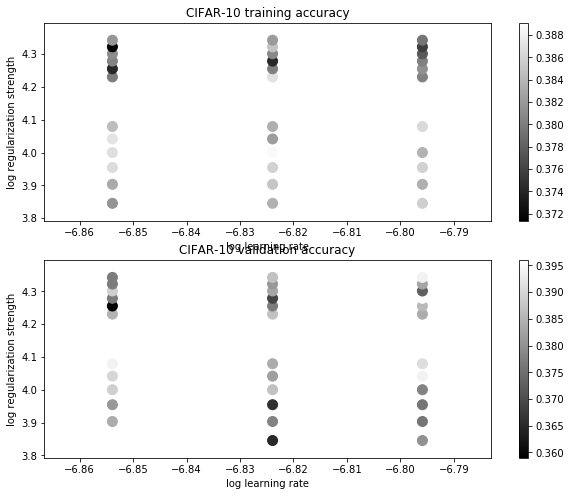

In [22]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [23]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print ('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.367000


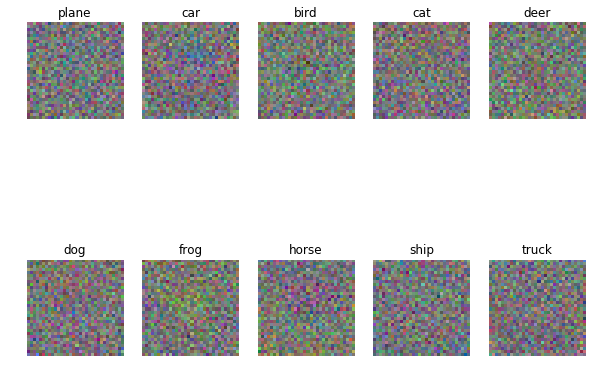

In [26]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*